# Container for data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class Program:
    # this class contains in a structured manner matrices and biases
    # which encode the semantics of the program network, in the same fashion
    # of the source code of a program
    def __init__(self, topology , activation_functions_list):
        self.topology = topology
        self.activation_functions_list = activation_functions_list
        self.W = [ 0 for t in topology[:-1]]
        self.b = [ 0 for t in topology[:-1]]
    def random_init_weights(self):
        for layer in range(len(self.topology[:-1])):
            self.W[layer] = np.random.normal( size = (self.topology[layer + 1] , self.topology[layer] ) )**2
            size = self.W[layer].shape[0] * self.W[layer].shape[1] 
            for i in range(size - int(np.sqrt(size))):
                r = np.random.choice(len(self.W[layer]))
                c = np.random.choice(len(self.W[layer].T))
                self.W[layer][r,c] = 0.   # adding some sparsity
                
            self.b[layer] = np.random.normal( size = self.topology[layer + 1] )
    def print(self):
        for i,layer in enumerate(self.topology[:-1]):
            print("layer %d->%d "%(i,i+1))
            print("W.shape = %s \t b.shape = %s" % (str(self.W[i].shape),str(self.b[i].shape)))
    def visualize_weights(self):
        for w in self.W:
            print(w.shape)
            plt.figure(figsize=(10,10))
            plt.imshow(w > 0.)
            

(30, 5)
(30, 30)
(1, 30)


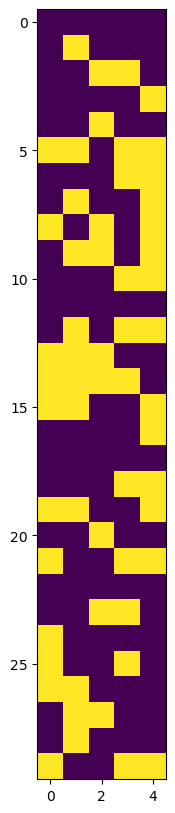

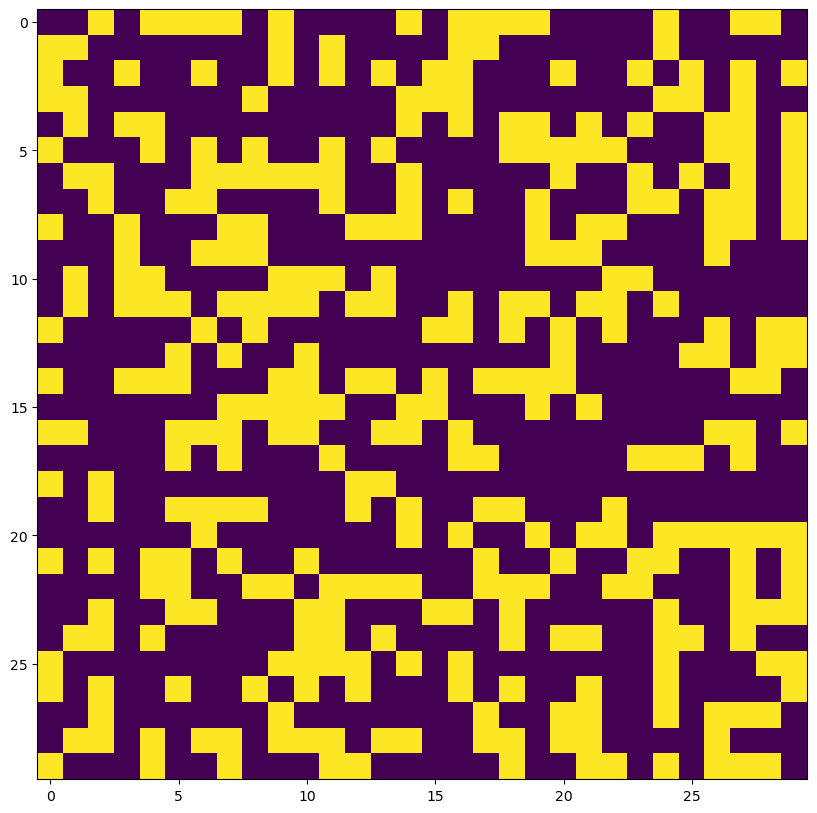

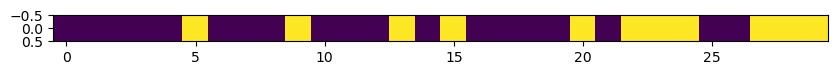

In [2]:
rete = Program([5,30,30,1], ["RELU","RELU","LINEAR"])
rete.random_init_weights()
rete.visualize_weights()

# Intermediate representation

In [3]:
class c:
    # every element is a node in the tree.
    # the first argument denotes the name of the node ; the possible next arguments are a list of the sons.
    # Note that nodes without sons are simply leaf (eg. ADD, MUL,...)
    def __init__(self, ID, *args):
        self.id   = ID
        self.sons = list()
        for arg in args:
            self.sons.append(arg)
    def print(self,level = 0):
        print( ("\t" * level) + str(self.id) )
        for s in self.sons:
            s.print(level + 1)
    def __str__(self):
        ret = str(self.id)
        if len(self.sons) > 0:
            ret += "("
            for s in self.sons:
                ret += str(s)
                if s != self.sons[-1]:
                    ret += ','
            ret += ")"
        return ret
    def flatten(self):
        ret = []
        ret += [self.id]
        for s in self.sons:
            ret += s.flatten()
        return ret
        
C = c("BINOP", c("ADD"), c("TEMP",c(1)), c("CONST",c(2)) )        
C.flatten()

['BINOP', 'ADD', 'TEMP', 1, 'CONST', 2]

In [4]:
def IR(program, compile_time_data = True):
    # for every layer
    print("y = input")
    ret = list()
    
    for layer,t in enumerate(program.topology[1:]):
        IR_instruction = c("COMMENT", c("START"))
        print(IR_instruction)
        ret.append(IR_instruction)
        
        f = program.activation_functions_list[layer]
        R_offset = t
        for i in range(len(program.b[layer])): # for every row
            #print("R[%d] = 0" % (i))
            #print("MOVE( TEMP(%d) , CONST(0) )" % (i + R_offset))
            IR_instruction = c(
                    "MOVE",
                     c("TEMP" , c(i + R_offset) ),
                     c("CONST", c(0))
            )
            print(str(IR_instruction))
            ret.append(IR_instruction)
        for i in range(len(program.W[layer])): # for every row
            for j in range(len(program.W[layer].T)): # for every column
                #print(" >> R[%d] +=  W[%d->%d][%d,%d] * Y[%d]" % (i,layer,layer+1,i,j,j))
                if compile_time_data:
                    if( program.W[layer][i,j] != 0):
                        # if there is zero is useless to compute the contribution
                        #print("->MOVE(TEMP(%d),BINOP(ADD,TEMP(%d),BINOP(MUL,CONST(%f),TEMP(%d)))) " % (i + R_offset,i + R_offset, program.W[layer][i,j],i )) # COMPILE DATA HYPOTHESIS
                        IR_instruction = c(
                            "MOVE",
                            c("TEMP",
                                c(i + R_offset)
                            ),
                            c("BINOP",
                                c("ADD"),
                                c("TEMP",
                                    c(i + R_offset)
                                ),
                                c("BINOP",
                                    c("MUL"),
                                    c("CONST",
                                         c(program.W[layer][i,j])
                                     ),
                                    c("TEMP",
                                     c(i)
                                     )
                                )
                            )
                        )
                        print(IR_instruction)
                        ret.append(IR_instruction)
                    else:
                        print("# here there was a 0 so we exploit sparsity ")
                else:
                    print("#TODO")
                    #N = len(program.W[layer])
                    #ijth_element_position = i*N + j
                    #print("MOVE(TEMP(%d),BINOP(ADD,TEMP(%d),BINOP(MUL,MEM(BINOP(ADD,&W,CONST(%d))),TEMP(%d))))" % (i + R_offset,i + R_offset, ijth_element_position,i )) # COMPILE DATA HYPOTHESIS
        for i in range(len(program.b[layer])): # for every row
            # a priori in compile time since the amount of "repetitions" doens't scale quadratically , in opposite to weights
            #print("->MOVE(TEMP(%d),BINOP(ADD,TEMP(%d),CONST(%f)))" % (i, i + R_offset , program.b[layer][i]) )
            IR_instruction = c("MOVE",
                                c("TEMP",
                                 c(i)
                                 ),
                                c("BINOP",
                                 c("ADD"),
                                 c("TEMP",
                                   c(i + R_offset)
                                  ),
                                 c("CONST",
                                  c(program.b[layer][i])
                                  )
                                 )
                                )
            print((IR_instruction))
            ret.append(IR_instruction)
        for i in range(len(program.b[layer])): # for every row
            #print("y[%d] = f(y[%d])" % (i,i))
            #print("MOVE( TEMP(%d) , CALL( %s, TEMP(%d) ) )" % (i,f,i) )
            IR_instruction = c("MOVE",
                c("TEMP",
                     c(i)
                 ),
                c("CALL",
                     c(f),
                     c("TEMP",
                          c(i)
                      )
                 )
            )
            print(IR_instruction)
            ret.append(IR_instruction)
        IR_instruction = c("COMMENT", c("END"))
        print(IR_instruction)
        ret.append(IR_instruction)
    return ret
intermediate_representation = IR(rete,True)

y = input
COMMENT(START)
MOVE(TEMP(30),CONST(0))
MOVE(TEMP(31),CONST(0))
MOVE(TEMP(32),CONST(0))
MOVE(TEMP(33),CONST(0))
MOVE(TEMP(34),CONST(0))
MOVE(TEMP(35),CONST(0))
MOVE(TEMP(36),CONST(0))
MOVE(TEMP(37),CONST(0))
MOVE(TEMP(38),CONST(0))
MOVE(TEMP(39),CONST(0))
MOVE(TEMP(40),CONST(0))
MOVE(TEMP(41),CONST(0))
MOVE(TEMP(42),CONST(0))
MOVE(TEMP(43),CONST(0))
MOVE(TEMP(44),CONST(0))
MOVE(TEMP(45),CONST(0))
MOVE(TEMP(46),CONST(0))
MOVE(TEMP(47),CONST(0))
MOVE(TEMP(48),CONST(0))
MOVE(TEMP(49),CONST(0))
MOVE(TEMP(50),CONST(0))
MOVE(TEMP(51),CONST(0))
MOVE(TEMP(52),CONST(0))
MOVE(TEMP(53),CONST(0))
MOVE(TEMP(54),CONST(0))
MOVE(TEMP(55),CONST(0))
MOVE(TEMP(56),CONST(0))
MOVE(TEMP(57),CONST(0))
MOVE(TEMP(58),CONST(0))
MOVE(TEMP(59),CONST(0))
# here there was a 0 so we exploit sparsity 
# here there was a 0 so we exploit sparsity 
# here there was a 0 so we exploit sparsity 
# here there was a 0 so we exploit sparsity 
# here there was a 0 so we exploit sparsity 
# here there was a 0 so we exp

# Simulated architecture
We decided to buld a simulator of a simple architecture in order to be able to have a standardized context of execution straight in our python notebook.
It has a basic instruction set; also the idea of having a "simpler machine" than our  laptop is useful in the context of interpreting the project as a tool to work with embedded systems

In [5]:
from enum import Enum
import numpy as np
    
class AsmInstruction:
    def __init__(self,cmd,A,B,C):
        self.cmd = cmd
        self.A   = A
        self.B   = B
        self.C   = C
        
class Arch:
    class ASM_INSTRUCTION_NAME(Enum):
        OUTPUT = 0
        ADD = 1
        SUB = 2
        MUL = 3
        DIV = 4
        ADDI = 5
        SUBI = 6
        MULI = 7
        DIVI = 8
        JZ   = 9   # JUMP IF EQUAL ELSE CONTINUE
        JNZ  = 10  # JUMP IF EQUAL ELSE CONTINUE
        JGT  = 11  # JUMP IF GREATER OR EQUAL ELSE CONTINUE
        LW   = 12  # LOAD  MEMORY VALUE
        SW   = 13  # STORE MEMORY VALUE
        
    def __init__(self, N_registers, Memory_size = 1024 * 8):
        self.N_registers = N_registers
        
        self.MEMORY_OFFSET = N_registers + 1
        self.PC_id       = N_registers              # id of the program counter register
        self.registers   = np.zeros(N_registers     # floating point registers
                                   + 1              # program counter
                                   + Memory_size    # memory cells treated as registers for the moment
                                   )
        
        self.instruction = {}
        # 
        self.instruction[self.ASM_INSTRUCTION_NAME.OUTPUT] = lambda b,c : self.registers[b] + (print("OUTPUT:\t" + str(self.registers[c])) == None)*0
        self.instruction[self.ASM_INSTRUCTION_NAME.ADD]  = lambda b,c : self.registers[b] + self.registers[c]
        self.instruction[self.ASM_INSTRUCTION_NAME.SUB]  = lambda b,c : self.registers[b] - self.registers[c]
        self.instruction[self.ASM_INSTRUCTION_NAME.MUL]  = lambda b,c : self.registers[b] * self.registers[c]
        self.instruction[self.ASM_INSTRUCTION_NAME.DIV]  = lambda b,c : self.registers[b] / self.registers[c]
        self.instruction[self.ASM_INSTRUCTION_NAME.ADDI] = lambda b,c : self.registers[b] + c
        self.instruction[self.ASM_INSTRUCTION_NAME.SUBI] = lambda b,c : self.registers[b] - c
        self.instruction[self.ASM_INSTRUCTION_NAME.MULI] = lambda b,c : self.registers[b] * c
        self.instruction[self.ASM_INSTRUCTION_NAME.DIVI] = lambda b,c : self.registers[b] / c
        self.instruction[self.ASM_INSTRUCTION_NAME.JZ]   = lambda b,c : (self.registers[b] == 0 ) * (c - 1)  + self.registers[self.PC_id]
        self.instruction[self.ASM_INSTRUCTION_NAME.JNZ]  = lambda b,c : (self.registers[b] != 0 ) * (c - 1)  + self.registers[self.PC_id]
        self.instruction[self.ASM_INSTRUCTION_NAME.JGT]  = lambda b,c : (self.registers[b] >= 0 ) * (c - 1)  + self.registers[self.PC_id]
        self.instruction[self.ASM_INSTRUCTION_NAME.LW]   = lambda b,c : self.registers[b]  # LW $dest $source
        self.instruction[self.ASM_INSTRUCTION_NAME.SW]   = lambda b,c : self.registers[b]  # SW $dest $source 
        
    def run(self,program):
        # program is a list of instructions
        self.registers[self.PC_id] = 0.
        while self.registers[self.PC_id] < len(program):
            p = program[self.registers[self.PC_id].astype(int)]
            self.registers[p.A] = self.instruction[p.cmd](p.B,p.C)
            self.registers[self.PC_id] += 1
    def print(self):
        print(self.registers[:self.N_registers])

In [6]:
def asm_addi(architettura, a,b,c):
    return AsmInstruction(architettura.ASM_INSTRUCTION_NAME.ADDI,a,b,c)
def asm_subi(architettura, a,b,c):
    return AsmInstruction(architettura.ASM_INSTRUCTION_NAME.SUBI,a,b,c)
def asm_muli(architettura, a,b,c):
    return AsmInstruction(architettura.ASM_INSTRUCTION_NAME.MULI,a,b,c)
def asm_divi(architettura, a,b,c):
    return AsmInstruction(architettura.ASM_INSTRUCTION_NAME.DIVI,a,b,c)
def asm_add(architettura, a,b,c):
    return AsmInstruction(architettura.ASM_INSTRUCTION_NAME.ADD,a,b,c)
def asm_sub(architettura, a,b,c):
    return AsmInstruction(architettura.ASM_INSTRUCTION_NAME.SUB,a,b,c)
def asm_mul(architettura, a,b,c):
    return AsmInstruction(architettura.ASM_INSTRUCTION_NAME.MUL,a,b,c)
def asm_div(architettura, a,b,c):
    return AsmInstruction(architettura.ASM_INSTRUCTION_NAME.DIV,a,b,c)
def asm_output(architettura,a):
    return AsmInstruction(architettura.ASM_INSTRUCTION_NAME.OUTPUT,0,0,a)
def asm_sw(architettura,dest,source):
    return AsmInstruction(architettura.ASM_INSTRUCTION_NAME.SW,dest + architettura.MEMORY_OFFSET,source,0)
def asm_lw(architettura,dest,source):
    return AsmInstruction(architettura.ASM_INSTRUCTION_NAME.LW,dest,source  + architettura.MEMORY_OFFSET,0)
def asm_jz(architettura,registro,salto):
    return AsmInstruction(architettura.ASM_INSTRUCTION_NAME.JZ, architettura.PC_id, registro, salto)
def asm_jnz(architettura,registro,salto):
    return AsmInstruction(architettura.ASM_INSTRUCTION_NAME.JNZ, architettura.PC_id, registro, salto)
def asm_jgt(architettura,registro,salto):
    return AsmInstruction(architettura.ASM_INSTRUCTION_NAME.JGT, architettura.PC_id, registro, salto)

In [7]:
architettura = Arch(16)
#programma = [
#    AsmInstruction(architettura.ASM_INSTRUCTION_NAME.ADDI,   0,0,1 ),
#    AsmInstruction(architettura.ASM_INSTRUCTION_NAME.ADDI,   1,1,2 ),  
#    AsmInstruction(architettura.ASM_INSTRUCTION_NAME.ADDI,   0,0,4 ),
#    AsmInstruction(architettura.ASM_INSTRUCTION_NAME.OUTPUT, 2,2,0 ),   
#    AsmInstruction(architettura.ASM_INSTRUCTION_NAME.SW,   124,1,0 ),   
#    AsmInstruction(architettura.ASM_INSTRUCTION_NAME.LW,   3,124,0 ),
#    AsmInstruction(architettura.ASM_INSTRUCTION_NAME.OUTPUT, 0,0,3 )     
#]

programma = [
    asm_addi(architettura,0,0,1),
    asm_addi(architettura,1,1,2),
    asm_addi(architettura,0,0,4),
    asm_output(architettura,0)  ,
    asm_jz(architettura,0, 3),
    asm_sw(architettura, 124, 0),
    asm_lw(architettura, 3, 124),
    asm_output(architettura,3)
]
architettura.run(programma)

OUTPUT:	5.0
OUTPUT:	5.0


# Temporary Variable Usage
Dal momento che la liveness viene definita a priori nella rappresentazione intermedia nel momento in cui c'é una sovrascrittura.
In ogni coppia di layer $(layer_i, layer_{i+1})$ trovo le variabili temporali piu utilizzate.
Queste diventeranno i miei registri.
Step successivo : la posizione delle varibaili che invece vanno scritte in memoria va ottimizzata in modo da sfruttare il piu possibile la data locality

In [8]:
def most_used_register(ir):
    statistics_per_block = list()
    def add_usage_statistics(statistics_per_block, temp_name ):
        # takes the name of a temporary variabile and counts it as used in the statistics dictionary
        old_value = statistics_per_block[-1].get(temp_name)
        if old_value == None:
            old_value = 0
        statistics_per_block[-1][temp_name] = old_value + 1
    
    for ir_instruction in ir:
        if(ir_instruction.id == "COMMENT"):
            if(ir_instruction.sons[0].id == "START"):
                statistics_per_block.append({})  # we put a dictionary
            
        unrolled_ir = ir_instruction.flatten()
        temp_used   = list()
        for u,val in zip(unrolled_ir[:-1],unrolled_ir[1:]):
            if u == "TEMP":
                temp_used.append(val)
        for t in temp_used:
            add_usage_statistics(statistics_per_block, t)
    
    ret = list()
    for stat in statistics_per_block:
        arr = []
        for s in stat:
            arr.append( [ s, stat[s]] )
        arr = np.array(arr)
        arr = arr[ arr[:,1].argsort()[-1::-1] ]
        ret.append(arr)
    return ret


def register_allocation(statistics_list, register_names):
    ret = list()
    for stat in statistics_list:
        allocation = list()
        for s,r in zip(stat,register_names):
            allocation.append([s[0],r])
        for i in range(len(register_names), len(stat)):
            allocation.append([stat[i][0],"memory"])
        ret.append(np.array(allocation))
    return ret
    
stats = most_used_register(intermediate_representation)  
print(stats)
register_allocation(stats,["A","B","C","D","E","F"])

[array([[44, 10],
       [35, 10],
       [59,  8],
       [51,  8],
       [39,  8],
       [42,  8],
       [43,  8],
       [45,  8],
       [49,  8],
       [38,  8],
       [ 5,  7],
       [14,  7],
       [ 9,  6],
       [32,  6],
       [57,  6],
       [36,  6],
       [37,  6],
       [48,  6],
       [56,  6],
       [55,  6],
       [ 8,  6],
       [53,  6],
       [21,  6],
       [12,  6],
       [13,  6],
       [15,  6],
       [40,  6],
       [19,  6],
       [29,  6],
       [27,  5],
       [26,  5],
       [23,  5],
       [ 2,  5],
       [ 6,  5],
       [ 7,  5],
       [10,  5],
       [18,  5],
       [25,  5],
       [28,  4],
       [46,  4],
       [31,  4],
       [58,  4],
       [50,  4],
       [24,  4],
       [34,  4],
       [54,  4],
       [33,  4],
       [ 1,  4],
       [ 3,  4],
       [16,  4],
       [20,  4],
       [ 4,  4],
       [22,  3],
       [17,  3],
       [ 0,  3],
       [11,  3],
       [41,  2],
       [47,  2],
       [52,  

[array([['44', 'A'],
        ['35', 'B'],
        ['59', 'C'],
        ['51', 'D'],
        ['39', 'E'],
        ['42', 'F'],
        ['43', 'memory'],
        ['45', 'memory'],
        ['49', 'memory'],
        ['38', 'memory'],
        ['5', 'memory'],
        ['14', 'memory'],
        ['9', 'memory'],
        ['32', 'memory'],
        ['57', 'memory'],
        ['36', 'memory'],
        ['37', 'memory'],
        ['48', 'memory'],
        ['56', 'memory'],
        ['55', 'memory'],
        ['8', 'memory'],
        ['53', 'memory'],
        ['21', 'memory'],
        ['12', 'memory'],
        ['13', 'memory'],
        ['15', 'memory'],
        ['40', 'memory'],
        ['19', 'memory'],
        ['29', 'memory'],
        ['27', 'memory'],
        ['26', 'memory'],
        ['23', 'memory'],
        ['2', 'memory'],
        ['6', 'memory'],
        ['7', 'memory'],
        ['10', 'memory'],
        ['18', 'memory'],
        ['25', 'memory'],
        ['28', 'memory'],
        ['46', 'memory

# Memory allocation simulated annealing

### Compute correlation between temp vars
Costruisco un vettore di liste ${\bf v}, indicizzato dalle variabili temporali$ <br>
Si scorre lungo la rappresentazione intermedia ; per ogni istruzione, trovo l'elenco delle variabili temporali utilizzate.
Trovato questo elenco, aggiungo ad ogni elemento di $v$ 1 alle liste associate alla variabili temporali utilizzate, 0 alle altre

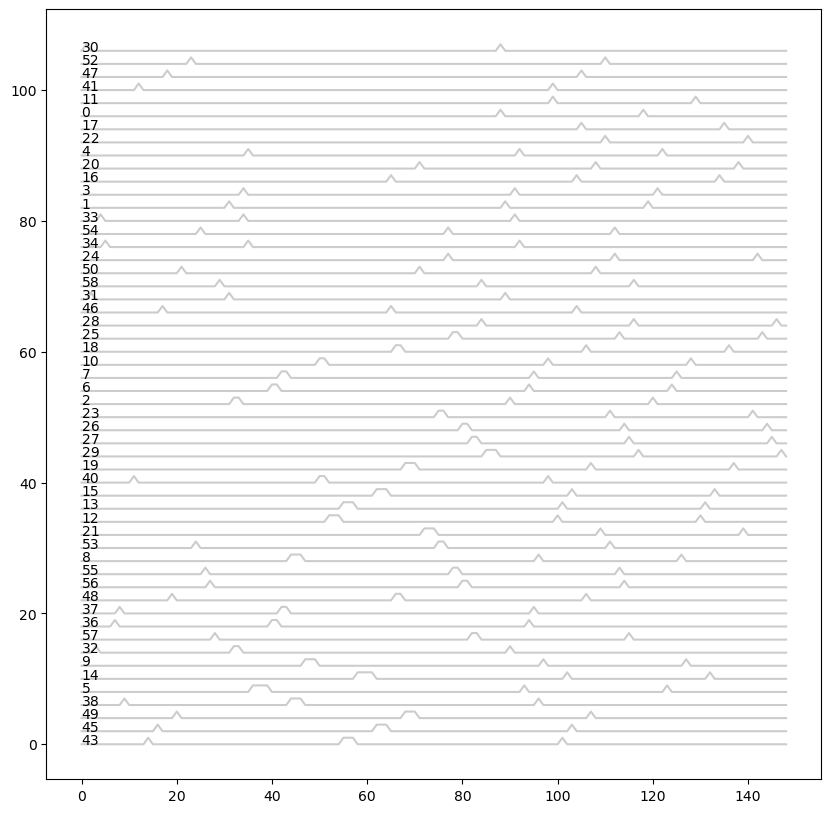

In [77]:
def correlation_between_temps(ir, register_allocation_output):
    # takes as input an intermediate repr and a register allocation output
    
    signals_per_block = list()
    
    def add_tick(signals_per_block, temp_variables , all_temp_variables):
        # push 0 in the lists of unused temps and 1 in the list of the used temp
        for t in all_temp_variables:
            signals_per_block[-1][t].append(0)
        for t in temp_variables:
            signals_per_block[-1][t][-1] = 1.
        
    curr_register_allocation_output = 0
    all_temp_variables = []
    
    for ir_instruction in ir:
        if(ir_instruction.id == "COMMENT"):
            if(ir_instruction.sons[0].id == "START"):
                signals_per_block.append({})
                all_temp_variables = register_allocation_output[curr_register_allocation_output][
                    register_allocation_output[curr_register_allocation_output][:,1] == "memory"
                ][:,0]
                for t in all_temp_variables:
                    signals_per_block[-1][t] = list()
                    
                curr_register_allocation_output += 1

        unrolled_ir = ir_instruction.flatten()
        temp_used   = list()
        
        for u,val in zip(unrolled_ir[:-1],unrolled_ir[1:]):
            if u == "TEMP":
                temp_used.append(val)        
        add_tick(signals_per_block, np.intersect1d( temp_used,all_temp_variables) , all_temp_variables)
    return signals_per_block

stats = most_used_register(intermediate_representation)  
RA_data = register_allocation(stats,["A","B","C","D","E","F"])
signals = correlation_between_temps(intermediate_representation, RA_data)
plt.figure(figsize=(10,10))
for i,s in enumerate(signals[0]):
    plt.annotate(s,(0,2 * i))
    plt.plot(np.array(signals[0][s]) + 2 * i, color = 'black' , alpha = 0.2,)

### Distance matrix

4.4


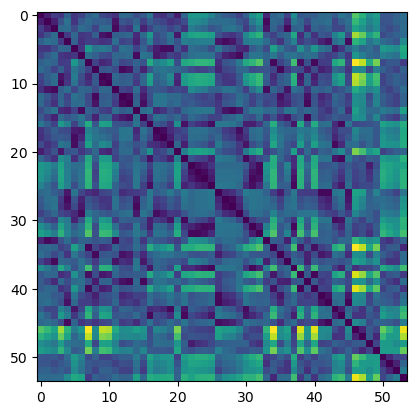

In [62]:
D = np.zeros((len(signals[0]),len(signals[0])))
for i,a in enumerate(signals[0]):
    for j,b in enumerate(signals[0]):  
        v_a = np.arange(len(signals[0][a]))[np.array(signals[0][a]) == 1.]
        v_b = np.arange(len(signals[0][b]))[np.array(signals[0][b]) == 1.]
        distanza = 0.5 * (np.mean([ np.min(np.abs(s_1 - v_b)) for s_1 in v_a]) + np.mean([ np.min(np.abs(s_2 - v_a)) for s_2 in v_b]))
        D[i,j] = distanza
plt.imshow(D)
print(D[0,1])
plt.show()

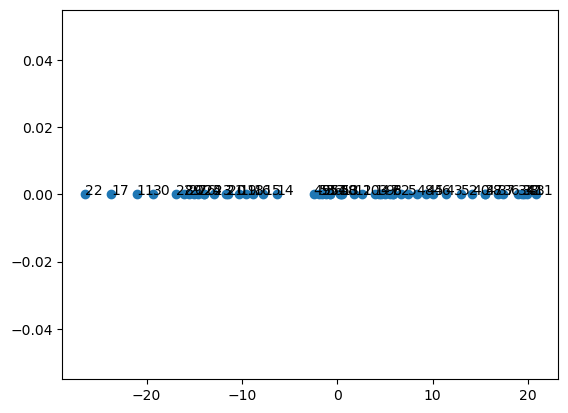

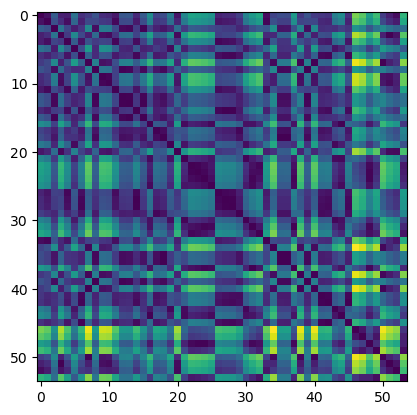

In [72]:
from sklearn.manifold import MDS
embedding = MDS( dissimilarity = 'precomputed',n_components = 1)
N = len(D)
X_proj    = embedding.fit_transform(D[:N,:N])
plt.scatter(X_proj[:,0][:N], 0 * X_proj[:,0][:N])
for i,s in enumerate(signals[0]):
    if i >= N:
        break
    plt.annotate(s, (X_proj[i,0],0))
plt.figure()
D_hat = np.array([
    [
            np.linalg.norm(x - x_)
        for x_ in X_proj
    ]
    for x in X_proj
])
plt.imshow(D_hat)

In [73]:
classifica = np.c_[X_proj, [s  for s in signals[0]]].astype(np.float16)
classifica = classifica[classifica[:,0].argsort()]
classifica

array([[-26.45  ,  22.    ],
       [-23.72  ,  17.    ],
       [-21.05  ,  11.    ],
       [-19.31  ,  30.    ],
       [-16.88  ,  28.    ],
       [-16.06  ,  29.    ],
       [-15.555 ,  27.    ],
       [-15.02  ,   0.    ],
       [-14.63  ,  26.    ],
       [-14.01  ,  24.    ],
       [-13.96  ,  25.    ],
       [-12.94  ,  23.    ],
       [-11.695 ,  21.    ],
       [-11.5   ,  20.    ],
       [-10.26  ,  19.    ],
       [ -9.56  ,  18.    ],
       [ -8.8   ,  16.    ],
       [ -7.742 ,  15.    ],
       [ -6.363 ,  14.    ],
       [ -2.486 ,  49.    ],
       [ -1.947 ,  53.    ],
       [ -1.598 ,  55.    ],
       [ -1.238 ,  56.    ],
       [ -0.814 ,  57.    ],
       [ -0.754 ,  54.    ],
       [  0.27  ,  58.    ],
       [  0.3425,  50.    ],
       [  0.4377,  13.    ],
       [  1.776 ,  12.    ],
       [  2.584 ,  10.    ],
       [  3.924 ,   1.    ],
       [  4.387 ,   3.    ],
       [  4.547 ,   4.    ],
       [  4.965 ,   9.    ],
       [  5.56

### Simulated annealing

In [316]:
def genera_permutazione(permutazione):
    a = np.random.choice(len(permutazione))
    b = np.random.choice(len(permutazione))
    ret = permutazione.copy()
    tmp = ret[a]
    ret[a] = ret[b]
    ret[b] = tmp
    return ret


def anneal(problem, size, T=15., T_end=1e-5, decading = 1. - 1e-5):
    # takes as input a function that takes as input a permutation and returns a cost
    np.random.seed(123)   # fix the random seed
    permutation = np.arange(size).astype(int)
    N = np.log(T_end/T) / np.log(decading)
    i = 0

    print("STEP ATTESI = %d" % N)
    losses = list()
    while T > T_end:
        T = decading * T

        new_permutation = genera_permutazione(permutation)
        if( problem(new_permutation) < problem(permutation)):
            permutation = new_permutation
        else:
            delta_E = np.abs( problem(new_permutation) - problem(permutation) )
            if delta_E == 0:
                delta_E = 1
            if np.random.uniform() > np.exp( - T / delta_E ):
                permutation = new_permutation

        losses.append(problem(permutation))
        if ( int( 1. * i / (N / 10)) < int( 1. * (i + 1.) / (N / 10))):
            print("STEP %.2f%%\tLOSS=%f\tT=%f" % ((i) / N * 100, problem(permutation),T ) )
        i += 1

N = 30
a = np.random.choice(100, size = N)

def problem(permutazione):
    a_ord = a[permutazione]
    loss  = (a_ord[1:] < a_ord[:-1]).sum()
    return loss

anneal(problem, N)

STEP ATTESI = 1422090
STEP 10.00%	LOSS=14.000000	T=3.618079
STEP 20.00%	LOSS=12.000000	T=0.872708
STEP 30.00%	LOSS=10.000000	T=0.210504
STEP 40.00%	LOSS=9.000000	T=0.050775
STEP 50.00%	LOSS=7.000000	T=0.012247
STEP 60.00%	LOSS=4.000000	T=0.002954
STEP 70.00%	LOSS=4.000000	T=0.000713
STEP 80.00%	LOSS=4.000000	T=0.000172
STEP 90.00%	LOSS=3.000000	T=0.000041
STEP 100.00%	LOSS=3.000000	T=0.000010


# Unoptimized assembler

Just translating the $\text{IR instructions}$ in $\text{ASM instructions}$

In [175]:
def assemble(IR_instruction):
    program = list()
    for ir in IR_instruction:
        # do some stuff
        
    return the program

IndentationError: expected an indented block (38417139.py, line 6)

In [258]:
np.random.choice( 10, size = (5) , replace = False)

array([[1, 5],
       [4, 0],
       [3, 9],
       [8, 6],
       [2, 7]])